In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Courses/ECE/ECE 5970/Biomedical ML Final Project - Melted Paper

/content/gdrive/My Drive/Courses/ECE/ECE 5970/Biomedical ML Final Project - Melted Paper


# Final Transfer Learning Model
### VGG-16, MIAS, DDSM, INbreast

In [3]:
import os, time, cv2, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.python.keras import Sequential, regularizers
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [4]:
normal_images_path = os.path.join('Datasets', 'final-dataset-augment', 'N')
benign_images_path = os.path.join('Datasets', 'final-dataset-augment', 'B')
malignant_images_path = os.path.join('Datasets', 'final-dataset-augment', 'M')

In [5]:
normal_images = os.listdir(normal_images_path)
benign_images = os.listdir(benign_images_path)
malignant_images = os.listdir(malignant_images_path)

In [6]:
images, labels = [], []

In [7]:
for img in normal_images: 
  labels.append('N')
  image = cv2.imread(os.path.join(normal_images_path, img), cv2.IMREAD_GRAYSCALE)
  image = image.reshape((image.shape[0], image.shape[1], 1))
  images.append(image)

In [8]:
for img in benign_images: 
  labels.append('B')
  image = cv2.imread(os.path.join(benign_images_path, img), cv2.IMREAD_GRAYSCALE)
  image = image.reshape((image.shape[0], image.shape[1], 1))
  images.append(image)

In [9]:
for img in malignant_images: 
  labels.append('M')
  image = cv2.imread(os.path.join(malignant_images_path, img), cv2.IMREAD_GRAYSCALE)
  image = image.reshape((image.shape[0], image.shape[1], 1))
  images.append(image)

In [10]:
le = LabelEncoder()
labels = to_categorical(le.fit_transform(labels))

Split Data 60-20-20 for training-validation-testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify=labels, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, shuffle=True)
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [12]:
print(len(y_train), len(y_test), len(y_val))

2316 773 773


In [13]:
def calculate_class_weights(y_train, le):
  y_train = le.inverse_transform(np.argmax(y_train, axis=1))
  weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
  return dict(enumerate(weights))
  # return class_weights

In [14]:
class_weights = calculate_class_weights(y_train, le)
print(class_weights)

{0: 1.0052083333333333, 1: 0.9784537389100126, 2: 1.0171277997364954}


VGG16 with L1L2 Regularization

In [15]:
def create_vgg16_model():
  input = Input(shape=(224, 224, 1))
  img_conc = Concatenate()([input, input, input])

  # VGG19 model with pre-trained ImageNet weights.
  model = Sequential()

  # Base convolutional layers
  model.add(VGG16(include_top=False, weights="imagenet", input_tensor=img_conc))

  # FC layers
  model.add(Flatten())
  FC = Sequential(name='FullyConnected')
  FC.add(Dense(units=512, kernel_regularizer=regularizers.l1_l2(l1=.001,l2=.001), activation='relu', name='Dense1'))
  FC.add(Dense(3, activation='sigmoid', kernel_initializer="random_uniform", name='Output'))
  model.add(FC)
  print(model.summary())
  print(FC.summary())
  return model

In [16]:
model = create_vgg16_model()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
FullyConnected (Sequential)  (None, 3)                 12847107  
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________
None
Model: "FullyConnected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 512)               12845568  
_________________________________________________________________
Output (Dense)  

In [17]:
def train_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size, title=""):
  # Only train fully connected layers by freezing CNN layers
  model.layers[0].trainable = False
  compile_model(model, 1e-5)
  history1 = fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size)
  training_results(history1, True, title)

  # Unfreeze all layers
  model.layers[0].trainable = True
  compile_model(model, 1e-5)
  history2 = fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size)
  training_results(history2, False, title)

  return history1, history2

def compile_model(model, learning_rate):
  model.compile(optimizer=Adam(learning_rate), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

def fit_model(model, X_train, X_val, y_train, y_val, class_weights, epoch, batch_size):
  history = model.fit(
      x=X_train,
      y=y_train,
      class_weight=class_weights,
      batch_size=batch_size,
      steps_per_epoch=len(X_train) // batch_size,
      validation_data=(X_val, y_val),
      validation_steps=len(X_val) // batch_size,
      epochs=epoch,
  )
  return history

In [18]:
def training_results(history, frozen, title):
  fig = plt.figure()
  n = len(history.history["loss"])
  plt.figure()
  plt.plot(np.arange(0, n), history.history["loss"], label="train set")
  plt.plot(np.arange(0, n), history.history["val_loss"], label="validation set")
  plt.title('Training Loss' + (' (Frozen)' if frozen else ' (Unfrozen)'))
  plt.legend(loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel('Cross Entropy Loss')
  plt.savefig('output/training-loss-' + str(frozen) + '-' + title + '.png')
  plt.show()

  fig = plt.figure()
  n = len(history.history["loss"])
  plt.figure()
  plt.plot(np.arange(0, n), history.history["categorical_accuracy"], label="train set")
  plt.plot(np.arange(0, n), history.history["val_categorical_accuracy"], label="validation set")
  plt.title('Training Accuracy ' + ('(Frozen)' if frozen else '(Unfrozen)'))
  plt.legend(loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.ylim(0, 1)
  plt.savefig('output/training-accuracy-' + str(frozen) + '-' + title + '.png')
  plt.show()

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
def evaluate_model(prediction, y_true, le, title=""):
  true_y = le.inverse_transform(np.argmax(y_true, axis=1))
  pred_y = le.inverse_transform(np.argmax(prediction, axis=1))
  print(len(pred_y))
  # Calculate accuracy
  accuracy = float('{:.4f}'.format(accuracy_score(true_y, pred_y)))
  print("Accuracy = {}\n".format(accuracy))

  cm = confusion_matrix(true_y, pred_y) 
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_norm[np.isnan(cm_norm)] = 0
  plot_confusion_matrix(cm_norm, le, title)

Epoch 1/20
115/115 [==============================] - 14s 122ms/step - loss: 95.4280 - categorical_accuracy: 0.8539 - val_loss: 90.8369 - val_categorical_accuracy: 0.9303
Epoch 2/20
115/115 [==============================] - 14s 123ms/step - loss: 86.3343 - categorical_accuracy: 0.9443 - val_loss: 81.9584 - val_categorical_accuracy: 0.9316
Epoch 3/20
115/115 [==============================] - 14s 123ms/step - loss: 77.4560 - categorical_accuracy: 0.9503 - val_loss: 73.1924 - val_categorical_accuracy: 0.9355
Epoch 4/20
115/115 [==============================] - 14s 125ms/step - loss: 68.8088 - categorical_accuracy: 0.9560 - val_loss: 64.7476 - val_categorical_accuracy: 0.9395
Epoch 5/20
115/115 [==============================] - 15s 126ms/step - loss: 60.5226 - categorical_accuracy: 0.9591 - val_loss: 56.6818 - val_categorical_accuracy: 0.9355
Epoch 6/20
115/115 [==============================] - 15s 128ms/step - loss: 52.6966 - categorical_accuracy: 0.9643 - val_loss: 49.1168 - val_cat

<Figure size 432x288 with 0 Axes>

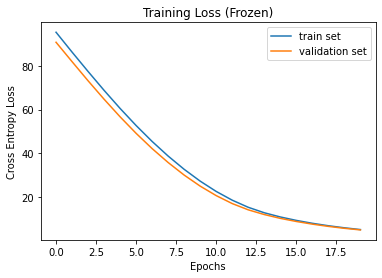

<Figure size 432x288 with 0 Axes>

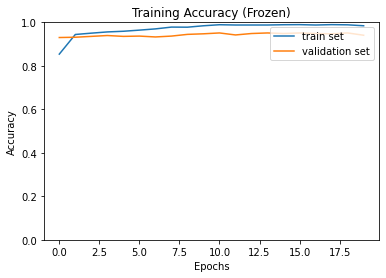

Epoch 1/20
115/115 [==============================] - 40s 347ms/step - loss: 4.5306 - categorical_accuracy: 0.9761 - val_loss: 4.5458 - val_categorical_accuracy: 0.9184
Epoch 2/20
115/115 [==============================] - 40s 344ms/step - loss: 4.1914 - categorical_accuracy: 0.9878 - val_loss: 4.2751 - val_categorical_accuracy: 0.9513
Epoch 3/20
115/115 [==============================] - 40s 346ms/step - loss: 3.9180 - categorical_accuracy: 0.9904 - val_loss: 4.0244 - val_categorical_accuracy: 0.9526
Epoch 4/20
115/115 [==============================] - 40s 345ms/step - loss: 3.6786 - categorical_accuracy: 0.9913 - val_loss: 3.8157 - val_categorical_accuracy: 0.9382
Epoch 5/20
115/115 [==============================] - 40s 344ms/step - loss: 3.4200 - categorical_accuracy: 0.9970 - val_loss: 3.6167 - val_categorical_accuracy: 0.9579
Epoch 6/20
115/115 [==============================] - 40s 345ms/step - loss: 3.2401 - categorical_accuracy: 0.9948 - val_loss: 3.4402 - val_categorical_acc

<Figure size 432x288 with 0 Axes>

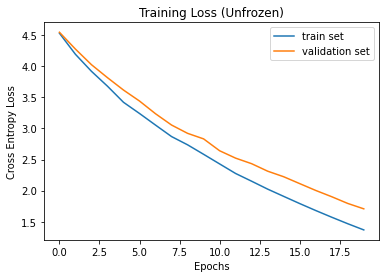

<Figure size 432x288 with 0 Axes>

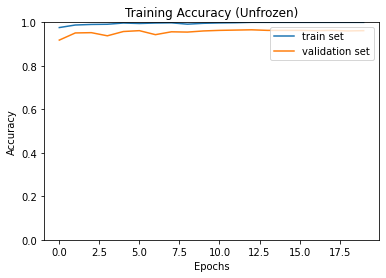

In [20]:
batch_size = 20
max_epoch = 20
history_frozen, history_unfrozen = train_model(model, X_train, X_val, y_train, y_val, class_weights, max_epoch, batch_size, '-l2=0.01')

In [21]:
def plot_roc(y_true, y_pred, le):
  fpr, tpr, roc_auc = {}, {}, {}

  for i in range(le.classes_.size):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(le.classes_))]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(le.classes_.size):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= le.classes_.size

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  fpr['micro'], tpr['micro'], _ = roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
  plt.figure(figsize=(8, 5))

  plt.plot([0, 1], [0, 1], 'k--', color='black', lw=2)
  plt.annotate('Random Guess', (.54, .49), color='black')

  plt.plot(fpr['micro'], tpr['micro'],
            label='Micro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='red', linestyle=':', lw=3)

  plt.plot(fpr['macro'], tpr['macro'],
            label='Macro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc['macro']),
            color='black', linestyle=':', lw=3)

  colors = ['#3972ba', '#ab923e', '#3bb300']
  for i, color in zip(range(len(le.classes_)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC of Class {0} (area = {1:0.2f})'
                      ''.format(le.classes_[i], roc_auc[i]))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.savefig('output/ROC.png')
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(fpr['micro'], tpr['micro'],
            label='Micro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='red', linestyle=':', lw=3)

  plt.plot(fpr['macro'], tpr['macro'],
            label='Macro-Average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc['macro']),
            color='black', linestyle=':', lw=3)

  colors = ['#3972ba', '#ab923e', '#3bb300']
  for i, color in zip(range(len(le.classes_)), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC of Class {0} (area = {1:0.2f})'
                      ''.format(le.classes_[i], roc_auc[i]))

  plt.xlim(0, 0.2)
  plt.ylim(0.8, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve (Top Left)')
  plt.legend(loc='lower right')
  plt.savefig('output/ROC-top-left.png')
  plt.show()

In [22]:
def plot_confusion_matrix(cm, le, title=""):
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap=plt.cm.Blues, vmin=0, vmax=1) 

  # Set labels, title, ticks and axis range.
  ax.set_xlabel('Predicted Classes')
  ax.set_ylabel('True Classes')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(le.classes_)
  ax.yaxis.set_ticklabels(le.classes_)
  plt.tight_layout()
  bottom, top = ax.get_ylim()
  plt.show()
  plt.savefig('output/confusion_mat' + title + '.png')

Validation

773
Accuracy = 0.9612



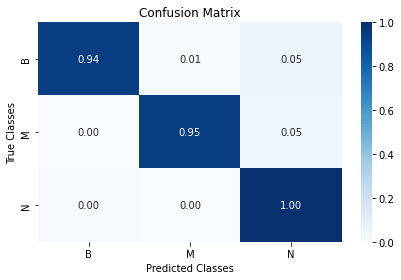

<Figure size 432x288 with 0 Axes>

In [23]:
prediction = model.predict(X_val, batch_size=20)
evaluate_model(prediction, y_val, le, '-val-l2=0.01')

Testing

773
Accuracy = 0.9664



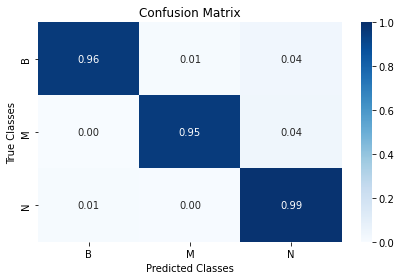

<Figure size 432x288 with 0 Axes>

In [24]:
predictions = model.predict(x=X_test)
evaluate_model(predictions, y_test, le, '-test-l2=0.01')

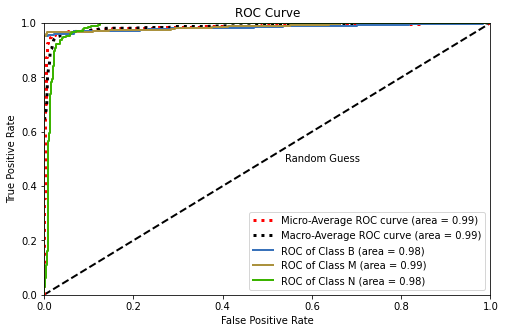

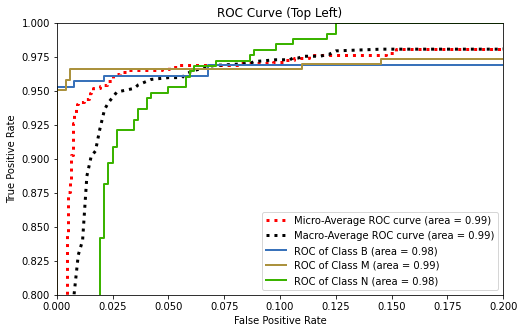

In [25]:
plot_roc(y_test, predictions, le)